## Imports

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import plotnine as p9
import statsmodels.formula.api as smf

## Load Yahoo Data

We will be getting Dividend Adjusted data -> which could be the difference between Yahoo and TradingView data

In [2]:
# tickers = ['SPY', 'TLT']
# ydata = yf.Tickers(tickers).download(period="max", auto_adjust=True)   # get dividend adjusted prices

Convert Yahoo Data to long-format

In [3]:
# data = (   # put data in long form
#     ydata
#     .dropna()
#     .stack(1, future_stack=True)
#     .reset_index()
#     [['Date', 'Ticker', 'Close']]
#     .sort_values(by=['Date', 'Ticker'])
# )

# data.head(5)

In [4]:
# # download historical data from Yahoo Finance to csv, file name data_<tickers>_2002-07-30_D.csv
# data.to_csv('data_SPY_TLT_2002-07-30_D.csv', index=False)

## Create return data for the various periods of Month defined by (N, M)

In [5]:
# read data from csv
data = pd.read_csv('data_SPY_TLT_2002-07-30_D.csv')
data['Date'] = pd.to_datetime(data['Date'])
print(data.info())
print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11704 entries, 0 to 11703
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    11704 non-null  datetime64[ns]
 1   Ticker  11704 non-null  object        
 2   Close   11704 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 274.4+ KB
None
        Date Ticker      Close
0 2002-07-30    SPY  59.177723
1 2002-07-30    TLT  37.055679
2 2002-07-31    SPY  59.320908
3 2002-07-31    TLT  37.514790
4 2002-08-01    SPY  57.772160


In [6]:
N = 15
M = 5

In [7]:
def flatten_indexes(df_: pd.DataFrame) -> pd.DataFrame:
    df_.columns = [x[1] + "_" + x[0] if x[1]!='' else x[0] for x in df_.columns]
    return df_

In [8]:
return_data = (
    data
    .assign(
        ym=lambda x: x['Date'] + pd.offsets.MonthEnd(0),          # Label in essence by year-month
    )
    .groupby(['Ticker', 'ym'])
    .apply(lambda x: x.assign(
        td=lambda y: range(1, len(y)+1)                           # for each ticker / month label the trading days from 1 to length(month)
    ), include_groups=False).reset_index([0, 1])

    .groupby(['Ticker'])
    .apply(lambda x: x.assign(
        ret=lambda y: y['Close'].pct_change()                     # Simple returns for return calcualtion, log returns for signal generation, though should be near identical
    ), include_groups=False).reset_index()
    
    .query('Date >= @dt.datetime(2002, 8, 1)')                    # Remove the two dates in July 2002
    [['Date', 'ym', 'Ticker', 'Close', 'ret', 'td']]
    
    .assign(
        som_flag=lambda x: np.select([x['td'] <= N], [1], [0]),   #  start of month  
        eom_flag=lambda x: np.select([x['td'] > N ], [1], [0]),   #  end of month
        nsm_flag=lambda x: np.select([x['td'] <= M], [1], [0]),   #  next start of month

        ret_som=lambda x: x['som_flag'] * x['ret'],               # create the simple returns for the various flags
        ret_eom=lambda x: x['eom_flag'] * x['ret'],
        ret_nsm=lambda x: x['nsm_flag'] * x['ret'],
    )
    
    [['Date', 'ym', 'Ticker', 'ret_som', 'ret_eom', 'ret_nsm']]   # retain only the relevant columns
    
    .pivot(index=['Date', 'ym'], columns=['Ticker'], values=['ret_som', 'ret_eom', 'ret_nsm'])  # convert to wide format for easier relative return manipulation
    .pipe(flatten_indexes)

    .assign(
        SPY_ret=lambda x: x['SPY_ret_som'] + x['SPY_ret_eom'],                                  # So we can compare against SPY 
        SPY_TLT_som=lambda x: x['SPY_ret_som'] - x['TLT_ret_som'],                              # Relative return calculations.
        SPY_TLT_eom=lambda x: x['SPY_ret_eom'] - x['TLT_ret_eom'],
        SPY_TLT_nsm=lambda x: x['SPY_ret_nsm'] - x['TLT_ret_nsm'],                              # Not we will have to apply a shift operator when using this value
    )
    [['SPY_ret', 'SPY_ret_eom', 'SPY_ret_nsm', 'TLT_ret_eom', 'TLT_ret_nsm', 'SPY_TLT_som', 'SPY_TLT_eom', 'SPY_TLT_nsm']]

    .groupby(['ym'])
    .agg(lambda x: (1+x).prod() - 1)
)

return_data.tail(5)

,SPY_ret,SPY_ret_eom,SPY_ret_nsm,TLT_ret_eom,TLT_ret_nsm,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm
ym,,,,,,,,
2025-06-30,0.051386,0.029493,0.016543,0.017057,-0.007096,0.010480,0.012145,0.023078
2025-07-31,0.023032,0.005120,0.004030,0.004623,-0.021519,0.033781,0.000007,0.025906
2025-08-31,0.020520,0.014948,0.000269,0.002199,0.012484,0.006702,0.012749,-0.012571
2025-09-30,0.035620,-0.000990,0.005860,0.007554,0.040198,0.007519,-0.008637,-0.033473
2025-10-31,0.031838,0.023984,0.004413,-0.009891,0.001347,-0.025525,0.034042,0.002909


## Relation between SOM and EOM relative returns

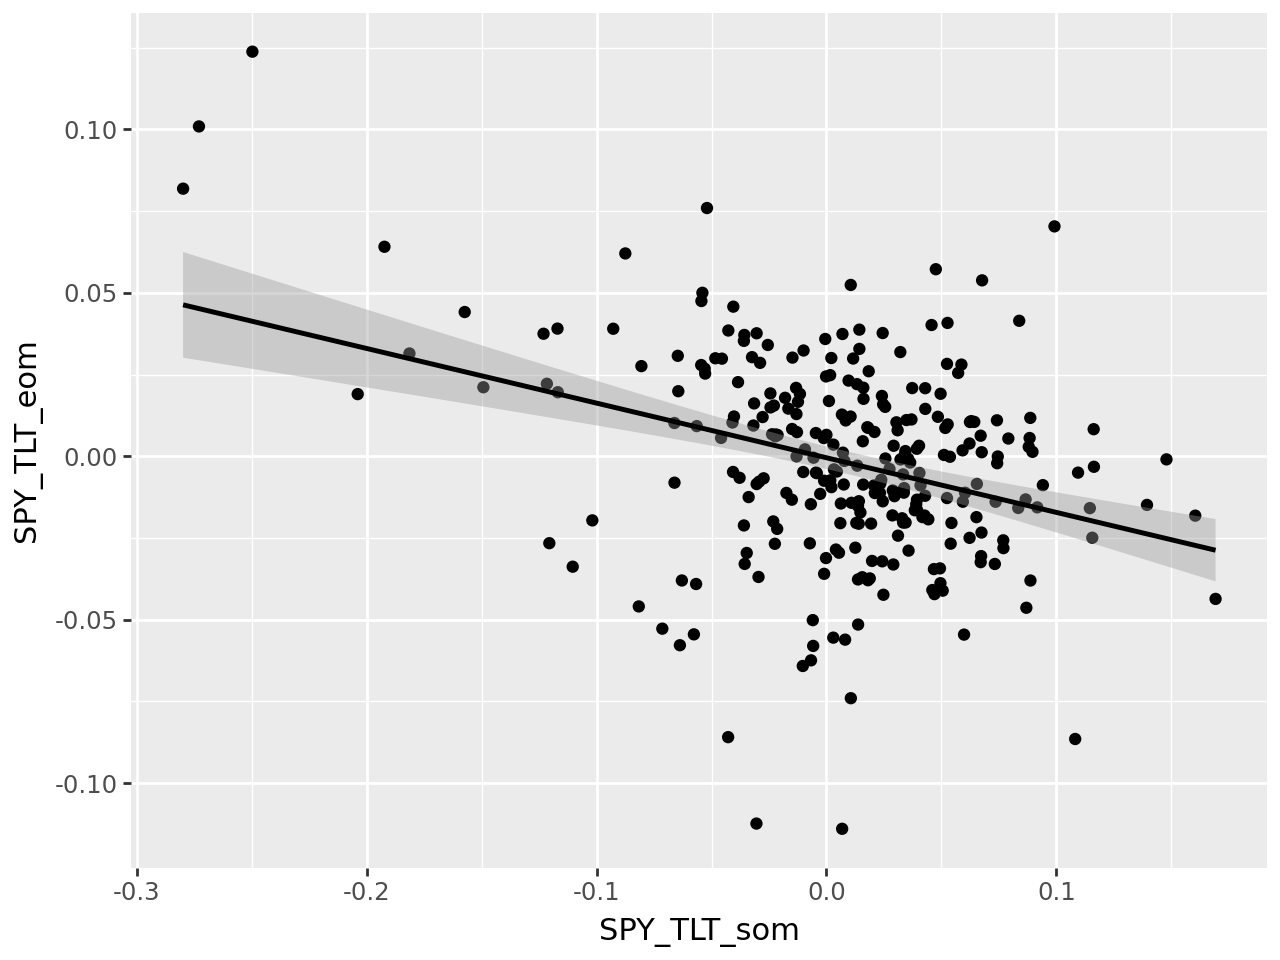

                            OLS Regression Results                            
Dep. Variable:            SPY_TLT_eom   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     35.81
Date:                Fri, 31 Oct 2025   Prob (F-statistic):           6.71e-09
Time:                        20:23:44   Log-Likelihood:                 591.45
No. Observations:                 279   AIC:                            -1179.
Df Residuals:                     277   BIC:                            -1172.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0005      0.002     -0.262      

In [9]:
(
    return_data
    .pipe(p9.ggplot)
    + p9.aes(x='SPY_TLT_som', y='SPY_TLT_eom')
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
).show()                                                           # have to explicitly call show otherwise only get print statement below

mod = smf.ols('SPY_TLT_eom ~ SPY_TLT_som', return_data)
res = mod.fit()
print(res.summary())

## Relationship between EOM and Next SOM

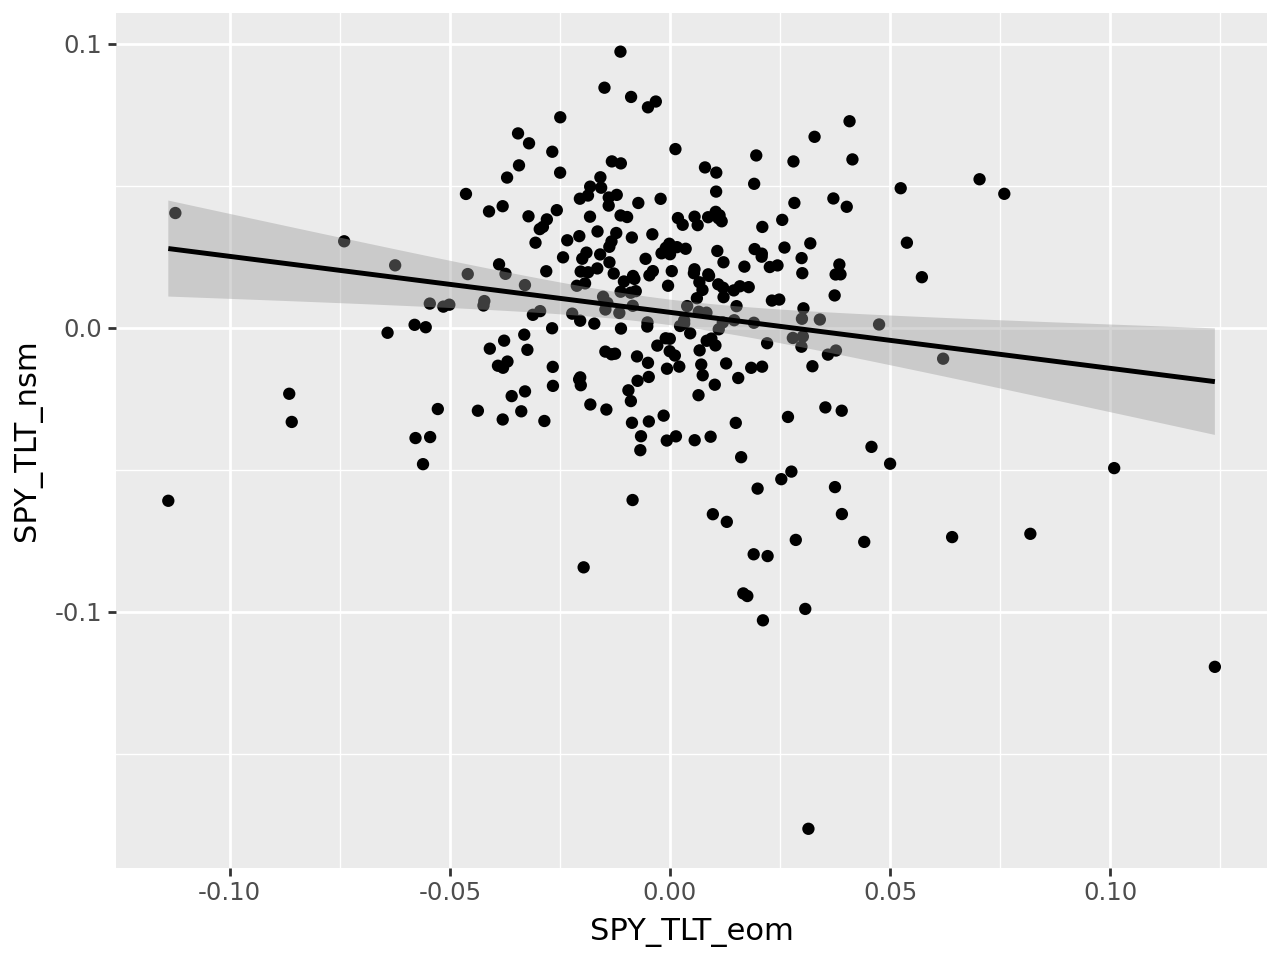

                            OLS Regression Results                            
Dep. Variable:            SPY_TLT_nsm   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     7.143
Date:                Fri, 31 Oct 2025   Prob (F-statistic):            0.00797
Time:                        20:23:44   Log-Likelihood:                 517.13
No. Observations:                 279   AIC:                            -1030.
Df Residuals:                     277   BIC:                            -1023.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0054      0.002      2.382      

In [10]:
(
    return_data
    .pipe(p9.ggplot)
    + p9.aes(x='SPY_TLT_eom', y='SPY_TLT_nsm')
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
).show()

mod = smf.ols('SPY_TLT_nsm ~ SPY_TLT_eom', return_data)
res = mod.fit()
print(res.summary())

## Relationship between SOM and Next SOM

c:\Users\calli\miniconda3\envs\data\Lib\site-packages\plotnine\layer.py:372: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


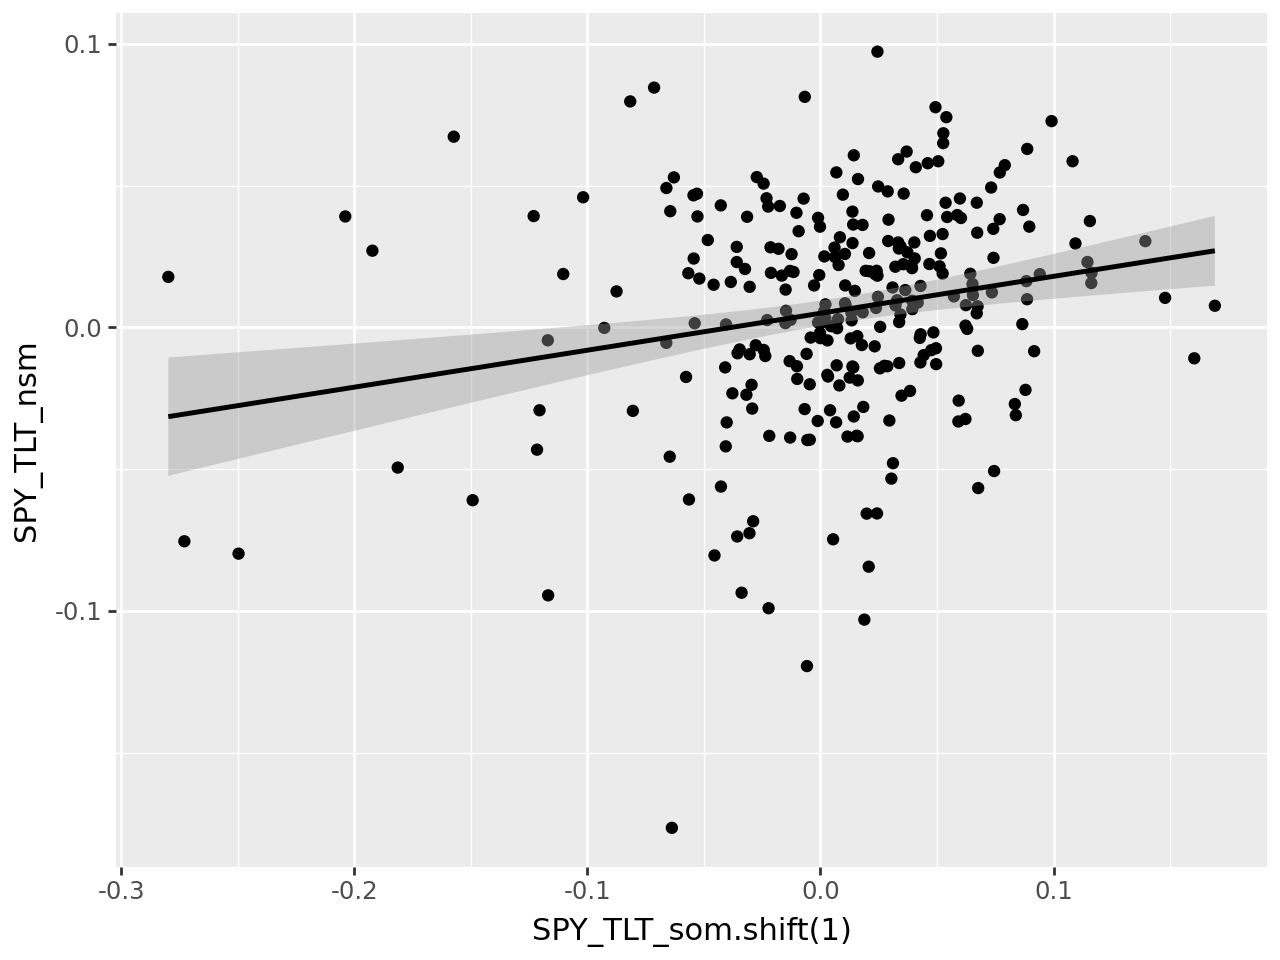

                            OLS Regression Results                            
Dep. Variable:            SPY_TLT_nsm   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     13.07
Date:                Fri, 31 Oct 2025   Prob (F-statistic):           0.000357
Time:                        20:23:44   Log-Likelihood:                 518.66
No. Observations:                 278   AIC:                            -1033.
Df Residuals:                     276   BIC:                            -1026.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0050 

In [11]:
(
    return_data
    .pipe(p9.ggplot)
    + p9.aes(x='SPY_TLT_som.shift(1)', y='SPY_TLT_nsm')
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
).show()

mod = smf.ols('SPY_TLT_nsm ~ SPY_TLT_som.shift(1)', return_data)
res = mod.fit()
print(res.summary())

## Backtesting

In [12]:
pl_data = (
    return_data
    .assign(
        flag=lambda x: np.select([x['SPY_TLT_som'] < 0], [1], -1),
        SPY_TLT_eom_pl=lambda x: x['flag'] * x['SPY_TLT_eom'],
        SPY_TLT_nsm_pl=lambda x: (-x['flag'].shift(1) * x['SPY_TLT_nsm']).fillna(0.0),
        pl=lambda x: x['SPY_TLT_eom_pl'] + x['SPY_TLT_nsm_pl'],
        cpl_nsm=lambda x: (1 + x['SPY_TLT_nsm_pl']).cumprod(),
        cpl_full=lambda x: (1 + x['pl']).cumprod(),
        SPY=lambda x: (1 + x['SPY_ret']).cumprod()
    )
    .reset_index()
)    

The cpl_full P&L curve is the combined P&L from month end and next start of month positions.

The cpl_nsm P&L curve is only for the next start of month

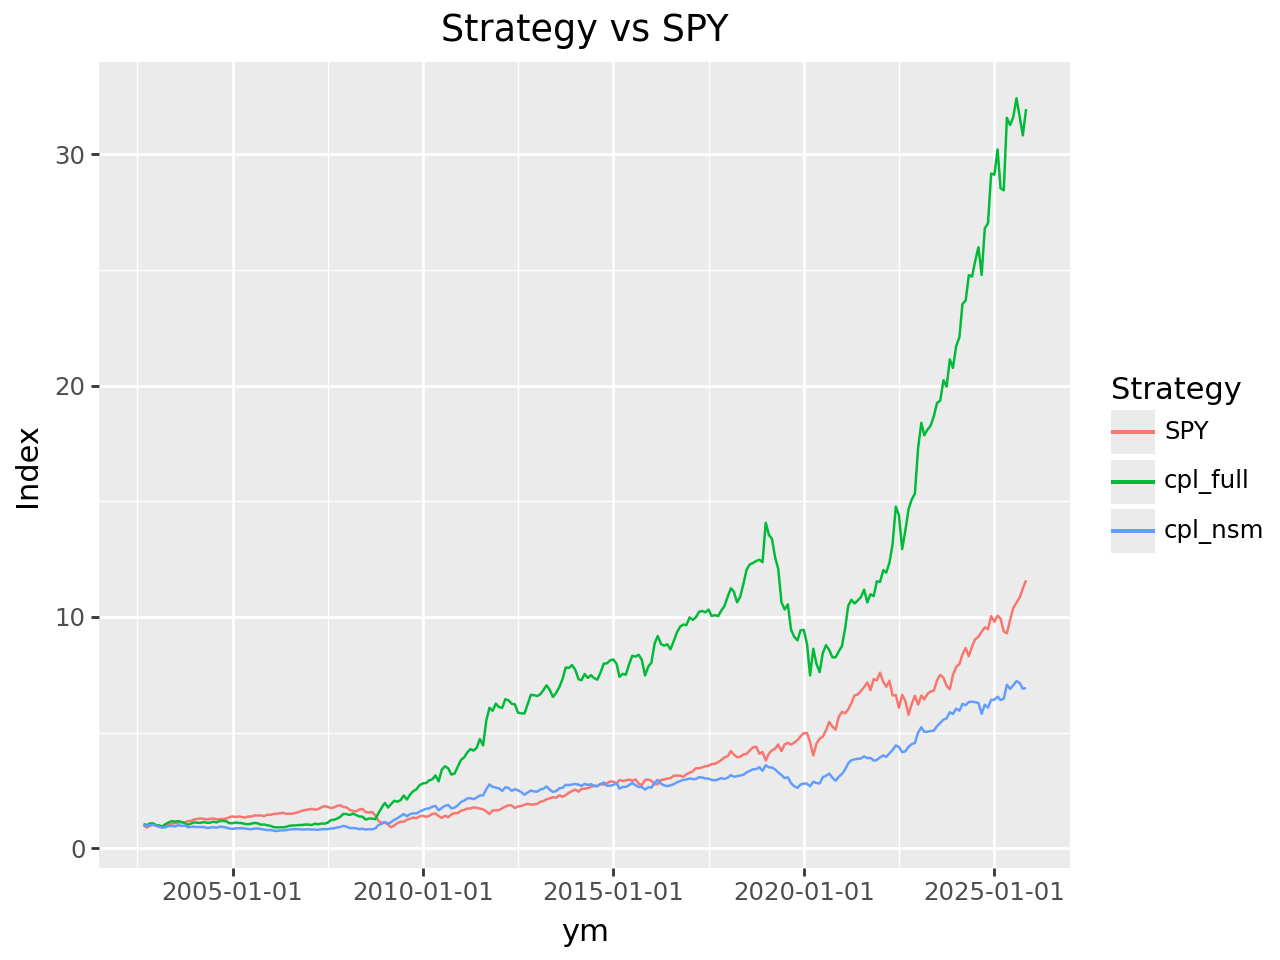

In [13]:
(
    pl_data
    [['ym', 'cpl_nsm', 'cpl_full', 'SPY']]
    .melt(id_vars='ym', var_name='Strategy', value_name='Index')
    .pipe(p9.ggplot)
    + p9.aes(x='ym', y='Index', color='Strategy')
    + p9.geom_line()
    + p9.ggtitle('Strategy vs SPY')
)

In [14]:
ret_strategy = pl_data['pl'].mean() * 12
vol_strategy = pl_data['pl'].std() * np.sqrt(12)
sr_strategy = ret_strategy / vol_strategy
mdd_strategy = (pl_data['cpl_full']/pl_data['cpl_full'].expanding().max() - 1.0).min()

ret_nsm = pl_data['SPY_TLT_nsm_pl'].mean() * 12
vol_nsm = pl_data['SPY_TLT_nsm_pl'].std() * np.sqrt(12)
sr_nsm = ret_strategy / vol_strategy
mdd_nsm = (pl_data['cpl_nsm']/pl_data['cpl_nsm'].expanding().max() - 1.0).min()

ret_spy = pl_data['SPY_ret'].mean() * 12
vol_spy = pl_data['SPY_ret'].std() * np.sqrt(12)
sr_spy = ret_spy / vol_spy
mdd_spy = (pl_data['SPY'] / pl_data['SPY'].expanding().max() - 1.0).min()

print(f'Next SOM Return = {ret_nsm:.2%}, Strategy Vol = {vol_nsm:.2%}, Strategy Sharpe = {sr_nsm:.2f}, Strategy Max DrawDown = {mdd_nsm:.2%}')
print(f'Strategy Return = {ret_strategy:.2%}, Strategy Vol = {vol_strategy:.2%}, Strategy Sharpe = {sr_strategy:.2f}, Strategy Max DrawDown = {mdd_strategy:.2%}')
print(f'SPY Return      = {ret_spy:.2%}, SPY Vol      = {vol_spy:.2%}, SPY Sharpe      = {sr_spy:.2f}, SPY Max DrawDown      = {mdd_spy:.2%}')

Next SOM Return = 9.21%, Strategy Vol = 13.17%, Strategy Sharpe = 0.92, Strategy Max DrawDown = -27.28%
Strategy Return = 16.55%, Strategy Vol = 17.91%, Strategy Sharpe = 0.92, Strategy Max DrawDown = -46.88%
SPY Return      = 11.68%, SPY Vol      = 14.73%, SPY Sharpe      = 0.79, SPY Max DrawDown      = -50.78%


## Properties of SPY and TLT

### Seasonal properties of TLT

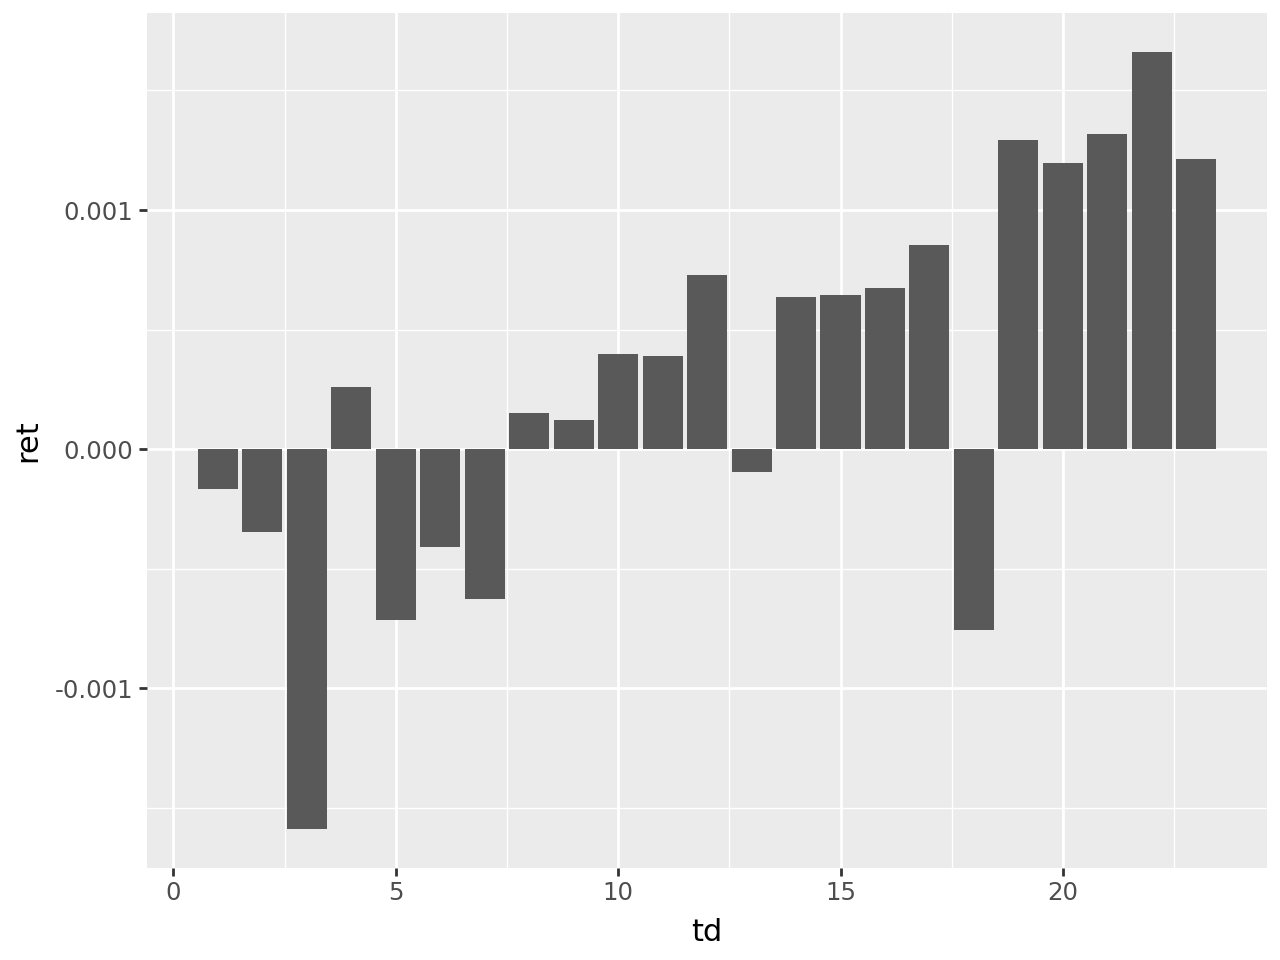

In [15]:
(
    data
    .query('Ticker == "TLT"')
    .assign(
        ym=lambda x: x['Date'] + pd.offsets.MonthEnd(0),
        ret=lambda x: x['Close'].pct_change()
    )
    .query('Date >= @dt.datetime(2002, 8, 1)')
    .groupby('ym')
    .apply(lambda x: x.assign(td=range(1, len(x) + 1)), include_groups=False).reset_index([0])
    .groupby('td')
    .agg({'ret': 'mean'})
    .reset_index()
    .pipe(p9.ggplot)
    + p9.aes(x='td', y='ret')
    + p9.geom_bar(stat='identity')
    
)

### Equity Risk Premium

In [16]:
# spy_ret = (
#     data
#     .query('Ticker == "SPY"')
#     .assign(
#         ret=lambda x: x['Close'].pct_change(),
#         retp=lambda x: np.select([x['ret'] > 0], [x['ret']], [np.nan]),
#         retn=lambda x: np.select([x['ret'] < 0], [x['ret']], [np.nan]),
#     )
#     [['Date', 'ret', 'retp', 'retn']]
#     .melt(id_vars='Date', value_name='retrn', var_name='type')  # cannot use return, since it is a reserved keyword in Python and screws up syntax below
# )

# print(f'mean of returns is = {spy_ret.query("type==`ret`").retrn.mean():.4%}')
# print(f'mean of positive returns = {spy_ret.query("(type==`retp`) & (~retrn.isna())").retrn.mean():.4%}')
# print(f'mean of negative returns = {spy_ret.query("(type==`retn`) & (~retrn.isna())").retrn.mean():.4%}')

# (
#     spy_ret
#     .pipe(p9.ggplot)
#     + p9.aes(x='factor(type)', y='retrn')
#     + p9.geom_boxplot()
# ).show()